# HOCNN

In [1]:
import torch
import torchvision
from torch import nn, optim
import cv2
import numpy as np
import json
from PIL import Image

from model.cnn_model import HOCNN

In [2]:
model = "hico/v1_2020-11-03_17-35/"
checkpoint_path = "checkpoint_25_epoch.pth"

PATH = "checkpoints/" + model + "epoch_train/" + checkpoint_path

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(PATH, map_location=device)
model = HOCNN()
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("model loaded")

model loaded


In [4]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()
print("faster rcnn loaded")

faster rcnn loaded


In [5]:
coco_dict = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

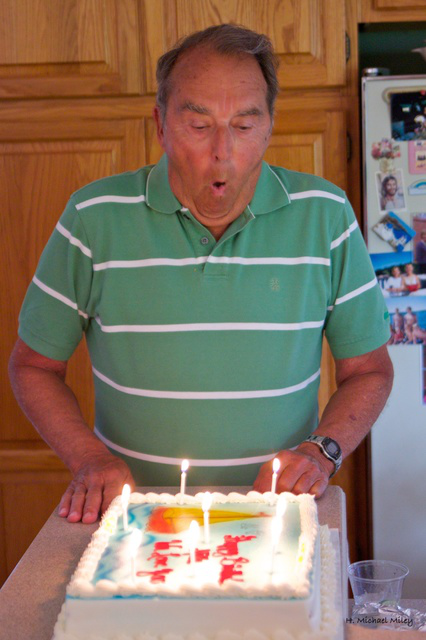

In [6]:
IMG_PATH = "datasets/hico/images/test2015/HICO_test2015_00000009.jpg"
im = Image.open(IMG_PATH)
display(im)

In [7]:
src = cv2.imread(IMG_PATH)
src = src/255
img_tensor = torch.from_numpy(src)
img_tensor = img_tensor.permute([2,0,1]).float().to(device) # chw format
rcnn_input = [img_tensor]

In [8]:
out = faster_rcnn(rcnn_input)[0]
out

c:\users\richa\.conda\envs\interact\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


{'boxes': tensor([[  6.8920,  26.8641, 414.7232, 560.8681],
         [ 67.4711, 488.0452, 329.6999, 605.1756],
         [346.4031, 558.0040, 412.9131, 624.4269],
         [358.8112,  89.4296, 426.0000, 327.8410],
         [  0.6532, 486.2336, 426.0000, 631.7109],
         [361.4802, 113.1236, 426.0000, 606.5250],
         [389.3194, 307.3214, 404.4879, 344.4660],
         [324.6661, 440.5870, 340.3954, 459.9552],
         [123.4690, 490.3802, 285.2935, 537.6798],
         [321.0410,  66.0575, 426.0000, 527.6386],
         [145.6103, 504.7353, 203.9054, 539.5911],
         [ 52.6686, 548.3517, 421.2318, 634.0630],
         [402.4986, 306.9792, 422.4349, 343.0501],
         [366.4783, 319.1895, 423.0343, 596.6888],
         [118.5232, 498.7008, 257.1842, 591.3948],
         [346.5673, 557.9322, 414.3058, 631.0748],
         [326.4393, 442.7896, 338.4019, 455.0135],
         [ 22.5626, 448.4963, 343.3405, 558.2162],
         [140.6712, 498.5044, 242.6884, 543.0065],
         [  0.0000, 47

In [9]:
human_bboxes, object_bboxes = [], []
object_dic = {}
for i in range(len(out['boxes'])):
    if out['scores'][i] < .9:
        break
    bbox = list(map(int, out['boxes'][i]))
    if out['labels'][i] == 1: # human
        human_bboxes.append(bbox)
    else: 
        object_bboxes.append(bbox)
        object_dic[coco_dict[out['labels'][i]]] = bbox
        
print(human_bboxes, object_bboxes)
print(object_dic)

[[6, 26, 414, 560]] [[67, 488, 329, 605], [346, 558, 412, 624]]
{'cake': [67, 488, 329, 605], 'cup': [346, 558, 412, 624]}


In [10]:
# apply masks
src = cv2.imread(IMG_PATH)
human_mask = np.zeros_like(src)
for bbox in human_bboxes:
    cv2.rectangle(human_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
human_bbox_img = cv2.bitwise_and(src, human_mask, mask=None)

obj_mask = np.zeros_like(src)
pairwise_mask = human_mask
for bbox in object_bboxes:
    cv2.rectangle(obj_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    cv2.rectangle(pairwise_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
obj_bbox_img = cv2.bitwise_and(src, obj_mask, mask=None)
pairwise_bbox_img = cv2.bitwise_and(src, pairwise_mask, mask=None)

# resize images
human_bbox_img = cv2.resize(human_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
obj_bbox_img = cv2.resize(obj_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
pairwise_bbox_img = cv2.resize(pairwise_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
#pose_img = cv2.resize(pose_img, (64, 64), interpolation=cv2.INTER_AREA)

human_bbox_img = torch.from_numpy(human_bbox_img).to(device)
obj_bbox_img = torch.from_numpy(obj_bbox_img).to(device)
pairwise_bbox_img = torch.from_numpy(pairwise_bbox_img).to(device)
#pose_img = torch.from_numpy(pose_img).to(device)


res_human_input = human_bbox_img.unsqueeze(0)
res_obj_input = obj_bbox_img.unsqueeze(0)
res_pairwise_input = pairwise_bbox_img.unsqueeze(0)
#res_pose_input = pose_img.unsqueeze(0)

res_human_input = res_human_input.permute([0,3,1,2]).float().to(device)
res_obj_input = res_obj_input.permute([0,3,1,2]).float().to(device)
res_pairwise_input = res_pairwise_input.permute([0,3,1,2]).float().to(device)

In [11]:
with torch.no_grad(): # Disable gradients for validation
    outputs = model.forward(res_human_input, res_obj_input, res_pairwise_input)

    preds = torch.argmax(outputs, dim=1)
   # ground_labels = torch.max(labels, 1)[1]

C:\Users\richa\berkeley\lp_proj\interact\model\cnn_model.py:173: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(summed_results)


In [12]:
with open('datasets/processed/hico/hoi_list.json') as f:
    hoi_list = json.load(f)
prediction = hoi_list[preds.item()]
print(prediction)

{'id': '143', 'object': 'horse', 'verb': 'train'}


## HOCNN With Random ID

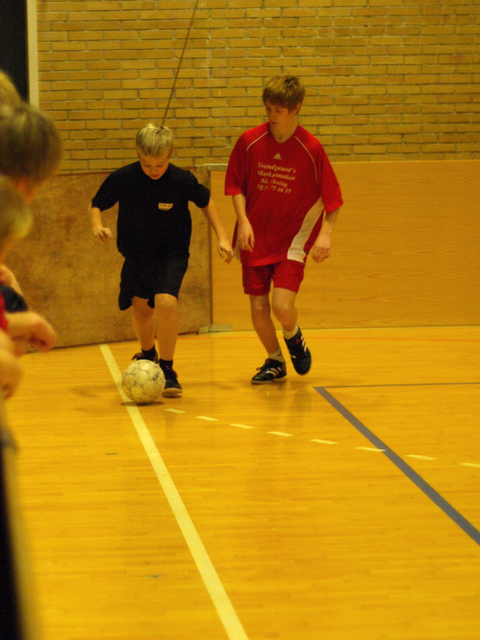

[[223, 76, 343, 386], [88, 116, 212, 399], [0, 71, 66, 348], [1, 63, 69, 613]] [[122, 359, 163, 403]]
{'sports ball': [122, 359, 163, 403]}


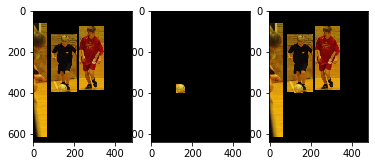

Predicted label: {'id': '591', 'object': 'wine_glass', 'verb': 'sip'}
Ground truth label: {'id': '494', 'object': 'sports_ball', 'verb': 'hold'}


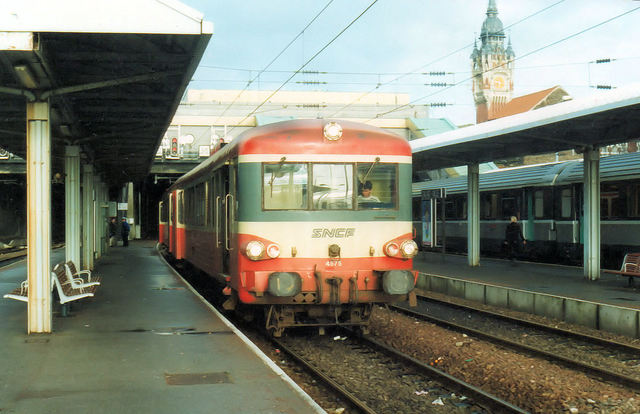

[[121, 217, 130, 247], [360, 181, 379, 200], [108, 217, 117, 246], [503, 215, 523, 259]] [[162, 112, 432, 341], [415, 155, 640, 263], [53, 259, 98, 307], [171, 136, 177, 155]]
{'train': [415, 155, 640, 263], 'bench': [53, 259, 98, 307], 'bottle': [171, 136, 177, 155]}


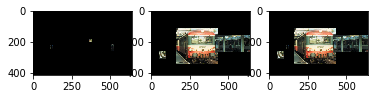

Predicted label: {'id': '058', 'object': 'bus', 'verb': 'exit'}
Ground truth label: {'id': '189', 'object': 'train', 'verb': 'exit'}


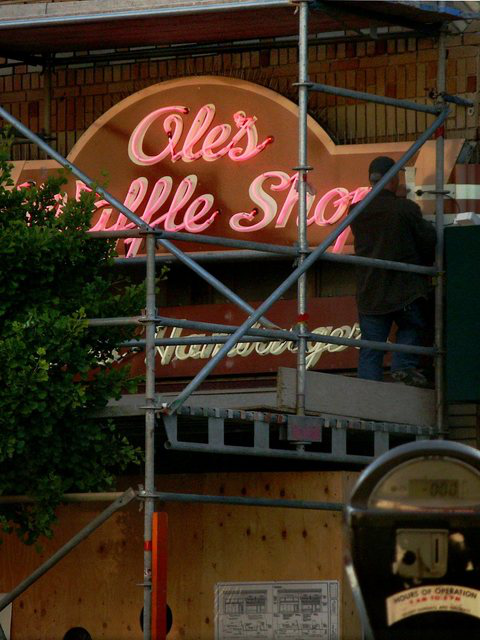

[[339, 152, 436, 390]] [[339, 437, 480, 639]]
{'parking meter': [339, 437, 480, 639]}


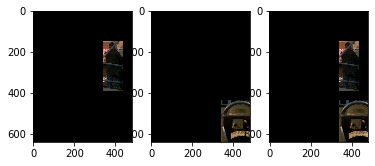

Predicted label: {'id': '020', 'object': 'bicycle', 'verb': 'sit_on'}
Ground truth label: {'id': '419', 'object': 'pizza', 'verb': 'buy'}


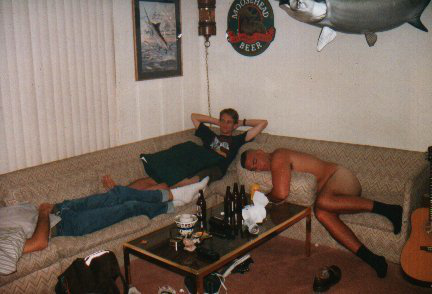

[[247, 148, 400, 268]] [[277, 1, 429, 53], [196, 188, 206, 232], [8, 121, 366, 278], [174, 213, 197, 231], [52, 248, 127, 293]]
{'bird': [277, 1, 429, 53], 'bottle': [196, 188, 206, 232], 'bed': [8, 121, 366, 278], 'bowl': [174, 213, 197, 231], 'backpack': [52, 248, 127, 293]}


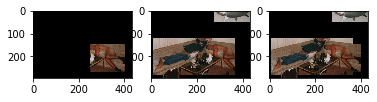

In [ ]:
from random import randint
from matplotlib import pyplot as plt

%matplotlib inline

with open('datasets/processed/hico/hoi_list.json') as f:
    hoi_list = json.load(f)
    
with open('datasets/processed/hico/anno_list.json') as f:
    anno_list = json.load(f)

def run_prediction(img_id):
    IMG_PATH = "datasets/hico/images/test2015/HICO_test2015_" + str(img_id).rjust(8, '0') + ".jpg"
    im = Image.open(IMG_PATH)
    display(im)
    
    src = cv2.imread(IMG_PATH)
    src = src/255
    img_tensor = torch.from_numpy(src)
    img_tensor = img_tensor.permute([2,0,1]).float().to(device) # chw format
    rcnn_input = [img_tensor]
    
    out = faster_rcnn(rcnn_input)[0]
    
    human_bboxes, object_bboxes = [], []
    object_dic = {}
    for i in range(len(out['boxes'])):
        if out['scores'][i] < .7:
            break
        bbox = list(map(int, out['boxes'][i]))
        if out['labels'][i] == 1: # human
            human_bboxes.append(bbox)
        else: 
            object_bboxes.append(bbox)
            object_dic[coco_dict[out['labels'][i]]] = bbox

    print(human_bboxes, object_bboxes)
    print(object_dic)
    
    # apply masks
    src = cv2.imread(IMG_PATH)
    human_mask = np.zeros_like(src)
    for bbox in human_bboxes:
        cv2.rectangle(human_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    human_bbox_img = cv2.bitwise_and(src, human_mask, mask=None)

    obj_mask = np.zeros_like(src)
    pairwise_mask = human_mask
    for bbox in object_bboxes:
        cv2.rectangle(obj_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
        cv2.rectangle(pairwise_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    obj_bbox_img = cv2.bitwise_and(src, obj_mask, mask=None)
    pairwise_bbox_img = cv2.bitwise_and(src, pairwise_mask, mask=None)

    # Visualize images
    f, axarr = plt.subplots(1,3)

    human_bbox_rgb = cv2.cvtColor(human_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[0].imshow(human_bbox_rgb)

    object_mask_rgb = cv2.cvtColor(obj_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[1].imshow(object_mask_rgb)

    pairwise_rgb = cv2.cvtColor(pairwise_bbox_img, cv2.COLOR_BGR2RGB)
    axarr[2].imshow(pairwise_rgb)
    
    plt.show()
    f.clf()
    
    # resize images
    human_bbox_img = cv2.resize(human_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
    obj_bbox_img = cv2.resize(obj_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
    pairwise_bbox_img = cv2.resize(pairwise_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)

    human_bbox_img = torch.from_numpy(human_bbox_img).to(device)
    obj_bbox_img = torch.from_numpy(obj_bbox_img).to(device)
    pairwise_bbox_img = torch.from_numpy(pairwise_bbox_img).to(device)


    res_human_input = human_bbox_img.unsqueeze(0)
    res_obj_input = obj_bbox_img.unsqueeze(0)
    res_pairwise_input = pairwise_bbox_img.unsqueeze(0)

    res_human_input = res_human_input.permute([0,3,1,2]).float().to(device)
    res_obj_input = res_obj_input.permute([0,3,1,2]).float().to(device)
    res_pairwise_input = res_pairwise_input.permute([0,3,1,2]).float().to(device)
    
    with torch.no_grad(): # Disable gradients for validation
        outputs = model.forward(res_human_input, res_obj_input, res_pairwise_input)
        preds = torch.argmax(outputs, dim=1)
        
    prediction = hoi_list[preds.item() + 1]
    print('Predicted label: ' + str(prediction))
    
    ground_data = [x for x in anno_list if x['global_id'] == "HICO_test2015_" + str(img_id).rjust(8, '0')][0]
    ground_truth = ground_data['hois'][0]
    img_id = int(ground_truth['id'])
    print('Ground truth label: ' + str(hoi_list[img_id]))
    
from time import sleep
while True:
    img_id = randint(1, 1000)
    run_prediction(img_id)
    sleep(5)